In [9]:
import torch
from attention_cam.mix_transformer import MixVisionTransformer
from attention_cam.segformer_head import SegFormerHead
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from attention_cam.camutils import (cam_to_label, cams_to_affinity_label, ignore_img_box,
                            multi_scale_cam, multi_scale_cam_with_aff_mat,
                            propagte_aff_cam_with_bkg, refine_cams_with_bkg_v2,
                            refine_cams_with_cls_label)

In [52]:
class Wetr(nn.Module):
    def __init__(self,num_classes=20, embedding_dim=256, stride=None, pretrained=None, pooling=None,):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.feature_stride = [4,8,16,32]
        self.stride = stride 

        self.encoder = MixVisionTransformer(stride=[4, 2, 2, 1])
        self.decoder = SegFormerHead(in_channels=[64, 128, 256, 512],feature_strides = [4, 8, 16, 32])
        self.classifier = classifier = nn.Conv2d(self.encoder.embed_dims[3],20,kernel_size=1,bias=False)
        
    
    def forward(self,x,cam_only=False):
        _x, _attns = self.encoder(x)
        _x1,_x2,_x3,_x4 = _x
        seg = self.decoder(_x)

        attn_cat = torch.cat(_attns[-2:],dim=1) ## [1,16,196,196]
        attn_cat = attn_cat + attn_cat.permute(0, 1, 3, 2)
        attn_proj = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1, bias=True)
        nn.init.kaiming_normal_(attn_proj.weight, a=np.sqrt(5), mode="fan_out")
        attn_pred = attn_proj(attn_cat) # MLP [B,1,N,N]
        attn_pred = torch.sigmoid(attn_pred)[:,0,...] #[1,N,N] 类似于squeeze
        
        
        if cam_only:
            cam_s4 = F.conv2d(_x4,self.classifier.weight,)
            return cam_s4, attn_pred
        

        pooling = F.adaptive_avg_pool2d
        cls_x4 = pooling(_x4,(1,1))
        cls_x4 = self.classifier(cls_x4)
        cls_x4 = cls_x4.view(-1,self.num_classes)
        return cls_x4, seg, _attns, attn_pred


torch.Size([2, 196, 196])
torch.Size([1, 20, 224, 224])
torch.Size([2, 441, 441])


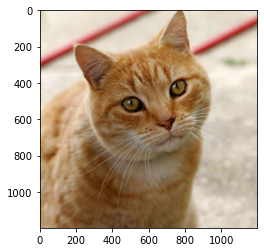

In [59]:
img_path = "/home/jaye/Documents/DeepLearning/08_ConvTrans/cat.jpg"     # 输入图片的路径
save_path = './cat_cam.jpg' 
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.2,0.2,0.2])])

img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.show
img = transform(img)
inputs = img.unsqueeze(0)
wetr = Wetr()
inputs_cat = torch.cat([inputs, inputs.flip(-1)], dim=0)
_cam, _aff_mat = wetr(inputs_cat, cam_only=True)
print(_aff_mat.size())
cams, aff_mat = multi_scale_cam_with_aff_mat(wetr, inputs=inputs, scales=[1.,0.5,1.5])
print(cams.size())
print(aff_mat.size())

torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 1, 1])
torch.Size([1, 20, 1, 1])
torch.Size([1, 20])
helllo torch.Size([1, 20, 14, 14])


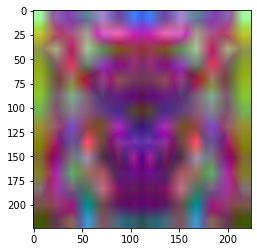

torch.Size([1, 20, 224, 224])


In [57]:
"""
IMAGE TEST
"""
from torch import conv2d


img_path = "/home/jaye/Documents/DeepLearning/08_ConvTrans/cat.jpg"     # 输入图片的路径
save_path = './cat_cam.jpg' 
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.2,0.2,0.2])])

img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.show
img = transform(img)
imgs = img.unsqueeze(0)
h = imgs.size()[-2]
w = imgs.size()[-1]


encoder = MixVisionTransformer(stride=[4, 2, 2, 1])
classifier = nn.Conv2d(encoder.embed_dims[3],20,kernel_size=1,bias=False)
_x, _attns = encoder(imgs)

"""decoder part"""
_x1,_x2,_x3,_x4 = _x
"""Test"""
print(_x4.size())
pooling = F.adaptive_avg_pool2d
cls_x4 = pooling(_x4,(1,1))
print(cls_x4.size())
cls_x4 = classifier(cls_x4)
print(cls_x4.size())
cls_x4 = cls_x4.view(-1,20)
print(cls_x4.size())

decoder = SegFormerHead(in_channels=[64, 128, 256, 512],feature_strides = [4, 8, 16, 32])
"""get the seg lable"""
seg = decoder(_x)  ##[B,num_classes,H,W]

""""""
attn_cat = torch.cat(_attns[-2:],dim=1) ## [1,16,196,196]
attn_cat = attn_cat + attn_cat.permute(0, 1, 3, 2)
attn_proj = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1, bias=True)
nn.init.kaiming_normal_(attn_proj.weight, a=np.sqrt(5), mode="fan_out")
attn_pred = attn_proj(attn_cat) # MLP [B,1,N,N]
attn_pred = torch.sigmoid(attn_pred)[:,0,...] #[1,N,N] 类似于squeeze

"""cam only"""
cam_s4 = F.conv2d(_x4,classifier.weight,)
print("helllo",cam_s4.size())
_cam = F.interpolate(cam_s4, size=(h,w), mode='bilinear', align_corners=False)
_cam = torch.max(_cam[:,...], _cam[:,...].flip(-1))

# cam = torch.sum(torch.stack(cam_list, dim=0), dim=0)
cam = _cam + F.adaptive_max_pool2d(-_cam, (1, 1))
cam /= F.adaptive_max_pool2d(cam, (1, 1)) + 1e-5
plt.imshow(cam[0,:3,:,:].permute(1,2,0).detach().numpy())
plt.show()
print(_cam.size())

In [60]:
scales = [1.,0.5,1.5]
np.argmax(scales)

2